# Load Data

## Import libraries

In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf
import tensorflow.keras as keras

from matplotlib import image
from matplotlib import pyplot as plt

from PIL import Image
from pathlib import Path

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16


## Mount Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load Training Data

In [17]:
classes = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

# Train directory options
full_training = '/content/drive/MyDrive/ImageClassificationProject/seg_train/seg_train/'
representitive_samples = '/content/drive/MyDrive/ImageClassificationProject/representitive/'
clean_training = '/content/drive/MyDrive/Train_data/seg_train/seg_train/'

# Test directory options
full_testing = '/content/drive/MyDrive/ImageClassificationProject/seg_test/seg_test/'


# Select directory to use
train_dir = clean_training
test_dir = full_testing

# Validation split
val_split = 0.2

test_data = tf.keras.preprocessing.image_dataset_from_directory(
                        directory=test_dir,
                        class_names=classes,
                        color_mode="rgb",
                        label_mode='categorical',
                        image_size=(150, 150),
                        shuffle=False,
                    )

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    )

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
    )


Training Data
Found 3010 files belonging to 6 classes.
Found 12951 images belonging to 6 classes.


## Print ImageDataGenerator Output Samples

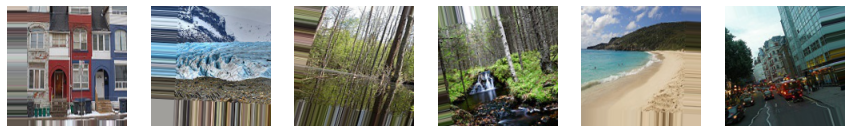

In [19]:
# fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(15,15))

# for j in range(6):
#     # convert to unsigned integers for plotting
#     image = next(train_generator)[0].astype('uint8')

#     # changing size from (1, 200, 200, 3) to (200, 200, 3) for plotting the image
#     image = np.squeeze(image)
    
#     # plot raw pixel data
#     ax[j].imshow(image)
#     ax[j].axis('off')

# Build CNN Model

In [5]:
import tensorflow as tf
import tensorflow.keras as keras

from keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import MaxPooling2D
from keras.layers import Activation
from keras.layers.experimental.preprocessing import Rescaling

# Custom CNN Architechture
# model = Sequential([
#         Conv2D(16, 3, padding='same', input_shape=(150, 150 ,3)),
#         Activation('relu'),
#         MaxPooling2D(),

#         Conv2D(32, 3, padding='same'),
#         Activation('relu'),
#         MaxPooling2D(),

#         Conv2D(64, 3, padding='same'),
#         Activation('relu'),
#         MaxPooling2D(),

#         Conv2D(128, 3, padding='same'),
#         Activation('relu'),
#         MaxPooling2D(),

#         Conv2D(128, 3, padding='same'),
#         Activation('relu'),
#         MaxPooling2D(),
        
#         Flatten(),
#         Dense(2048, activation='relu'),
#         Dropout(0.5),
#         Dense(2048, activation='relu'),
#         Dropout(0.5),

#         Dense(6, activation='softmax')
# ])

# VGG-16 Pre-trained
base = VGG16(include_top=False,weights='imagenet',input_shape=(150,150,3))
base.summary()

base.trainable = True
for layer in base.layers:
  if layer.name == 'block5_conv4':
    layer.trainable = True
  else:
     layer.trainable = False
 
model = Sequential()
model.add(base)
model.add(Flatten())
model.add(Dense(6, activation='softmax'))

# # VGG-19 Pre-trained
# base = VGG19(include_top=False,weights='imagenet',input_shape=(150,150,3))
# base.summary()

# base.trainable = True
# for layer in base.layers:
#   if layer.name == 'block5_conv4':
#     layer.trainable = True
#   else:
#      layer.trainable = False
 
# model = Sequential()
# model.add(base)
# model.add(Flatten())
# model.add(Dense(6, activation='softmax'))


model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

ValueError: ignored

# Train Model
We can either train the model from the beginning or load one of the sets of pre-trained weights.

In [6]:
batch_size = 64
num_epochs = 20
learning_rate = 0.001

# Name that will be used to name generated weight file
model_name = 'VGG-16_(SMRS_Training_Data).h5'

# Path that will be used to find weight file to load weights
path_of_weight_file = '/content/drive/MyDrive/ImageClassificationProject/clean_training_vgg19_test.h5'
weight_file = 'VGG-19_(Clean_Training_Data).h5'
name_of_weight_file = weight_file[:-3].split('_')

temp = ''
for word in name_of_weight_file:
    word = word.capitalize()
    temp += word + ' '

name_of_weight_file = temp

# Select if we are training the model or using saved weights
use_saved_weights = False

# Optimizers
opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
sgd = tf.keras.optimizers.SGD(learning_rate=learning_rate)

model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=opt)

if use_saved_weights == False:

    # Train the model
    history = model.fit(
        train_generator,
        batch_size=batch_size,
        steps_per_epoch= train_generator.samples // batch_size,
        epochs=num_epochs,
        )
    
    model.save_weights(model_name)
else:
    model_name = weight_file
    # Load pre-trained weights
    model.load_weights(path_of_weight_file)

Epoch 1/20
219/219 [==============================] - 2221s 10s/step - loss: 0.7458 - accuracy: 0.7089
Epoch 2/20
219/219 [==============================] - 1143s 5s/step - loss: 0.4328 - accuracy: 0.8351
Epoch 3/20
219/219 [==============================] - 576s 3s/step - loss: 0.4033 - accuracy: 0.8510
Epoch 4/20
219/219 [==============================] - 327s 1s/step - loss: 0.4286 - accuracy: 0.8462
Epoch 5/20
219/219 [==============================] - 175s 796ms/step - loss: 0.3883 - accuracy: 0.8564
Epoch 6/20
219/219 [==============================] - 109s 501ms/step - loss: 0.3830 - accuracy: 0.8548
Epoch 7/20
219/219 [==============================] - 73s 334ms/step - loss: 0.3493 - accuracy: 0.8729
Epoch 8/20
219/219 [==============================] - 59s 270ms/step - loss: 0.3986 - accuracy: 0.8588
Epoch 9/20
219/219 [==============================] - 53s 244ms/step - loss: 0.3642 - accuracy: 0.8695
Epoch 10/20
219/219 [==============================] - 48s 220ms/step - loss

# Evaluate Model

In [7]:
### Print out the evaluation results, including test loss and test accuracy.
score = model.evaluate(test_data)

95/95 [==============================] - 934s 10s/step - loss: 0.3334 - accuracy: 0.8887


# Predict Labels For Test Dataset

In [8]:
# Get predicted y values and y labels
y_pred = model.predict(test_data, workers=0).argmax(axis=1)
y_labels = np.concatenate([y for x, y in test_data], axis=0).argmax(axis=1)

# Plot Results

In [9]:
print("Results from", name_of_weight_file)

Results from Vgg-19 (clean Training Data) 


## Print Loss Graph

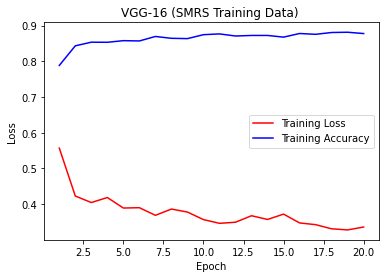

In [10]:
# Get model name and model name for files
model_name_file = model_name[:-3]
model_name = str(model_name[:-3]).split('_')
temp = ''
for word in model_name:
    temp += word + ' '
model_name = temp


# Get training and test loss histories
training_loss = history.history['loss']
training_accuracy = history.history['accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
fig, ax = plt.subplots()
plt.plot(epoch_count, training_loss, 'r-')
plt.plot(epoch_count, training_accuracy, 'b-')
ax.set_title(model_name)

plt.legend(['Training Loss', 'Training Accuracy'])
plt.xlabel('Epoch')
#plt.xticks(epoch_count)
plt.ylabel('Loss')

plt.savefig(str(model_name_file) +"_loss.png", dpi=300)
plt.show();


## Generate Confusion Matrix

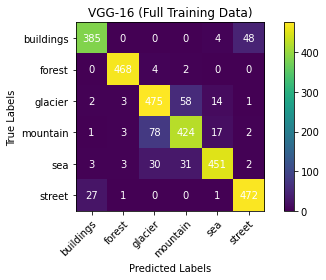

              precision    recall  f1-score   support

           0       0.92      0.88      0.90       437
           1       0.98      0.99      0.98       474
           2       0.81      0.86      0.83       553
           3       0.82      0.81      0.82       525
           4       0.93      0.87      0.90       520
           5       0.90      0.94      0.92       501

    accuracy                           0.89      3010
   macro avg       0.89      0.89      0.89      3010
weighted avg       0.89      0.89      0.89      3010

Test Loss: 0.3334117531776428
Test Accuracy: 0.8887042999267578


In [12]:
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_labels, y_pred)

# Plot the confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm)
plt.colorbar(im)

# We want to show all ticks...
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
# ... and label them with the respective list entries
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)

ax.set_ylabel("True Labels")
ax.set_xlabel("Predicted Labels")

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(classes)):
    for j in range(len(classes)):
        text = ax.text(j, i, cm[i, j],
                       ha="center", va="center", color="w")
        
    

ax.set_title(model_name)
fig.tight_layout()
plt.savefig(model_name_file +"_confusion_matrix.png", dpi=300)
plt.show()

from sklearn.metrics import classification_report

# Print out the classification report
print(classification_report(y_labels, y_pred))

print("Test Loss:", score[0])
print("Test Accuracy:", score[1])